In [1]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wrangle.wrangle_zillow()
df.head()

,bedrooms,bathrooms,area,tax_value,yearbuilt,taxamount,fips
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
18,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037.0
19,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037.0
20,3.0,2.0,1222.0,290492.0,1951.0,3870.25,6037.0


In [3]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test(df, 'tax_value')

In [4]:
X_train

,bedrooms,bathrooms,area,yearbuilt,taxamount,fips
894604,4.0,2.0,1694.0,1972.0,5289.08,6111.0
221576,3.0,3.0,2284.0,1990.0,5242.36,6037.0
2076710,3.0,2.5,1799.0,1968.0,766.38,6059.0
1051549,3.0,1.0,1024.0,1949.0,899.90,6037.0
1575944,2.0,1.0,660.0,1924.0,1533.73,6037.0
...,...,...,...,...,...,...
51283,4.0,2.5,2565.0,1969.0,8181.02,6059.0
979022,3.0,2.5,1812.0,1964.0,741.70,6059.0
1102170,5.0,4.0,2684.0,1948.0,3833.15,6037.0
1089315,4.0,2.0,1347.0,1962.0,5325.89,6037.0


In [5]:
y_train

894604     393986.0
221576     411257.0
2076710     79563.0
1051549     50267.0
1575944    120734.0
             ...   
51283      700000.0
979022      71447.0
1102170    300298.0
1089315    426200.0
244127     158430.0
Name: tax_value, Length: 1038469, dtype: float64

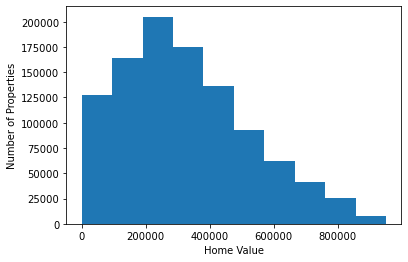

In [6]:
plt.hist(y_train)
plt.xlabel('Home Value')
plt.ylabel('Number of Properties')
plt.show()


In [7]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [8]:
tax_value_mean = y_train['tax_value'].mean()
y_train['tax_value_mean'] = tax_value_mean
y_validate['tax_value_mean'] = tax_value_mean

In [9]:
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_mean) ** .5

print('RMSE using Mean\nTrain/In-Sample: ', round(rmse_train,2),
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  198922.35 
Validate/Out-of-Sample:  199306.98


In [10]:
from sklearn.metrics import explained_variance_score

In [11]:
metric_df = pd.DataFrame(
    data=[{
        'model': 'mean_baseline',
        'rmse_validate': rmse_validate,
        'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_mean)
    }])

In [12]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,199306.978631,0.0


# LinearRegression (OLS)

In [13]:
lm = LinearRegression()

lm.fit(X_train, y_train.tax_value)

y_train['tv_pred_lm'] = lm.predict(X_train)
y_validate['tv_pred_lm'] = lm.predict(X_validate)

rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lm) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_lm) ** .5

print('RMSE for OLS using LinearRegression\nTrain/In-Sample: ', round(rmse_train,2),
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 2))

RMSE for OLS using LinearRegression
Train/In-Sample:  46067.64 
Validate/Out-of-Sample:  46014.59


In [14]:
metric_df = metric_df.append(
    {
        'model': 'OLS',
        'rmse_validate': rmse_validate,
        'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tv_pred_lm)
    }, ignore_index=True)

In [15]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,199306.978631,0.000000
1,OLS,46014.591430,0.946697


# LassoLars

In [21]:
lars = LassoLars(alpha=1)

lars.fit(X_train, y_train.tax_value)

y_train['tv_pred_lars'] = lars.predict(X_train)
y_validate['tv_pred_lars'] = lars.predict(X_validate)

rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lars) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_lars) ** .5

print('RMSE for LassoLars\nTrain/In-Sample: ', round(rmse_train,2),
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 2))

RMSE for LassoLars
Train/In-Sample:  46177.78 
Validate/Out-of-Sample:  46115.24


In [17]:
metric_df = metric_df.append(
{
    'model': 'LassoLars alpha 1',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.tax_value,
                                           y_validate.tv_pred_lars)
}, ignore_index=True)

In [18]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,199306.978631,0.000000
1,OLS,46014.591430,0.946697
2,LassoLars alpha 1,46115.240776,0.946464


# GLM

In [26]:
glm = TweedieRegressor(power = 2, alpha = 0)

glm.fit(X_train, y_train.tax_value)

y_train['tv_pred_glm'] = glm.predict(X_train)
y_validate['tv_pred_glm'] = glm.predict(X_validate)

rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_glm) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_glm) ** .5

print('RMSE for GLM using TweedieRegressor, power = 2 & alpha =0\nTrain/In-Sample: ', round(rmse_train,2),
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 2))

RMSE for GLM using TweedieRegressor, power = 2 & alpha =0
Train/In-Sample:  198922.35 
Validate/Out-of-Sample:  199306.98


In [27]:
metric_df = metric_df.append(
{
    'model': 'GLM power 2 & alpha 0',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.tax_value,
                                           y_validate.tv_pred_glm)
}, ignore_index=True)

In [28]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,199306.978631,0.000000
1,OLS,46014.591430,0.946697
2,LassoLars alpha 1,46115.240776,0.946464
3,GLM power 2 & alpha 0,199306.978631,0.000000


# PolynomialFeatures

In [29]:
pf = PolynomialFeatures(degree = 2)

X_train_d2 = pf.fit_transform(X_train)

X_validate_d2 = pf.transform(X_validate)

In [30]:
lm2 = LinearRegression(normalize=True)

lm2.fit(X_train_d2, y_train.tax_value)

LinearRegression(normalize=True)

In [32]:
y_train['tv_pred_lm2'] = lm2.predict(X_train_d2)
y_validate['tv_pred_lm2'] = lm2.predict(X_validate_d2)

rmse_train = mean_squared_error(y_train.tax_value, y_train.tv_pred_lm2) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tv_pred_lm2) ** .5

print('RMSE for OLS using LinearRegression, power = 2 & alpha =0\nTrain/In-Sample: ', round(rmse_train,2),
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 2))

RMSE for OLS using LinearRegression, power = 2 & alpha =0
Train/In-Sample:  43883.96 
Validate/Out-of-Sample:  43790.36


In [33]:
metric_df = metric_df.append(
{
    'model': 'Quadratic Model',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.tax_value,
                                           y_validate.tv_pred_lm2)
}, ignore_index=True)

In [34]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,199306.978631,0.000000
1,OLS,46014.591430,0.946697
2,LassoLars alpha 1,46115.240776,0.946464
3,GLM power 2 & alpha 0,199306.978631,0.000000
4,Quadratic Model,43790.363798,0.951726


## Takeaways

- The Quadratic model seems the best model for predicting home value with n=2 degrees
- OLS and Lasso + Lars were also close but the Polynomial Regression beat them both out nonetheless
- GLM ran on all distributions outside of normal were right in line with baseline so no improvement there